# Cat Tree Reviews to Images

### Import libraries

In [1]:
!pip install sentence-transformers faiss-cpu scikit-learn -q

In [2]:
!pip install scikit-learn matplotlib seaborn -q

In [80]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
import faiss
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import openai

/opt/miniconda3/envs/genAi_final_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1 - Preprocessing Reviews

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# print("Google Drive mounted successfully")

In [2]:
csv_path = 'walmart.csv'
df = pd.read_csv(csv_path)

In [3]:
df

date        user_name  \
0     21-Oct-25  WalmartCustomer   
1     11-Jul-25       bernadette   
2      8-Jun-25            Julie   
3     10-Mar-25             Rita   
4     11-Nov-24  WalmartCustomer   
...         ...              ...   
2100  15-Apr-23         Virginia   
2101   3-Jan-24            James   
2102  18-May-23          William   
2103   9-Oct-23            Ernie   
2104   4-Apr-23          Bharath   

                                                content  \
0     I recently got my hands on the MyMini 7-Egg Co...   
1     Wish I had found this years ago. No boiling wa...   
2     Cute and easy to use little egg cooker. \nIt h...   
3     this egg cooker is awesome! its super easy to ...   
4     The product is great but charging me more for ...   
...                                                 ...   
2100       1 article was missing. Old fashioned oatmeal   
2101  it's a great having a granddaughter loves it g...   
2102                         Easy To Use Good Quality !   
2103  Pretty cool gadget..quickly hard boils eggs......   
2104  worst pickup experience. took almost an hour t...   

                         rate                 b 2                    title  
0     5 out of 5 stars review   Verified Purchase                      NaN  
1     5 out of 5 stars review   Verified Purchase                      NaN  
2     5 out of 5 stars review   Verified Purchase  Great little egg cooker  
3     5 out of 5 stars review   Verified Purchase                      NaN  
4     4 out of 5 stars review   Verified Purchase                      NaN  
...                       ...                 ...                      ...  
2100                      NaN                Yay!                      NaN  
2101                      NaN   Love this product                      NaN  
2102                      NaN        Perfect Eggs                      NaN  
2103                      NaN  Perfect Every Time                      NaN  
2104                      NaN                 NaN                      NaN  

[2105 rows x 6 columns]

In [4]:
# Extract and clean reviews column
df_reviews = df[['content']].copy()

# Remove rows with NaN values
df_reviews = df_reviews.dropna()

# Rename column to 'review'
df_reviews = df_reviews.rename(columns={'content': 'review'})

# Reset index after dropping NaN
df_reviews = df_reviews.reset_index(drop=True)

df_reviews

review
0     I recently got my hands on the MyMini 7-Egg Co...
1     Wish I had found this years ago. No boiling wa...
2     Cute and easy to use little egg cooker. \nIt h...
3     this egg cooker is awesome! its super easy to ...
4     The product is great but charging me more for ...
...                                                 ...
2097       1 article was missing. Old fashioned oatmeal
2098  it's a great having a granddaughter loves it g...
2099                         Easy To Use Good Quality !
2100  Pretty cool gadget..quickly hard boils eggs......
2101  worst pickup experience. took almost an hour t...

[2102 rows x 1 columns]

In [5]:
# Save cleaned data
output_path = 'cleaned_walmart_reviews.csv'
df_reviews[['review']].to_csv(output_path, index=False)
print(f"\nCleaned reviews saved to: {output_path}")


Cleaned reviews saved to: cleaned_walmart_reviews.csv


## Part 2 - LLM Analysis of Reviews

### Combine all reviews

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
# print("Google Drive mounted successfully")

In [6]:
csv_path = 'cleaned_walmart_reviews.csv'
df_reviews = pd.read_csv(csv_path)


In [ ]:
# df_reviews = df_reviews.sample(n=800, random_state=42)   # ramdomly slect 800
# df_reviews = df_reviews.reset_index(drop=True)

In [7]:
df_reviews

review
0     I recently got my hands on the MyMini 7-Egg Co...
1     Wish I had found this years ago. No boiling wa...
2     Cute and easy to use little egg cooker. \nIt h...
3     this egg cooker is awesome! its super easy to ...
4     The product is great but charging me more for ...
...                                                 ...
2097       1 article was missing. Old fashioned oatmeal
2098  it's a great having a granddaughter loves it g...
2099                         Easy To Use Good Quality !
2100  Pretty cool gadget..quickly hard boils eggs......
2101  worst pickup experience. took almost an hour t...

[2102 rows x 1 columns]

In [8]:
# Combine all reviews into one large text corpus
all_reviews_text = "\n\n---REVIEW---\n\n".join(df_reviews['review'].tolist())

print(f"Total reviews: {len(df_reviews)}")
print(f"Combined text length: {len(all_reviews_text)} characters")
print(f"Estimated tokens: ~{len(all_reviews_text) // 4}")  # Rough estimate: 1 token ≈ 4 chars

# Preview combined text
print("\n--- First 2000 characters of combined reviews ---")
print(all_reviews_text[:2000])

Total reviews: 2102
Combined text length: 319149 characters
Estimated tokens: ~79787

--- First 2000 characters of combined reviews ---
I recently got my hands on the MyMini 7-Egg Cooker, and I have to say, I'm pretty pleased overall! 👍 The quality of the cooker seems top-notch, and it's holding up well so far. The price was also reasonable, making it a great value for what it offers. 🍳 I'm really happy with how easy it is to use, especially on busy mornings! I'm rating it good because it has definitely earned its place in my kitchen.

---REVIEW---

Wish I had found this years ago. No boiling water. Faster than boiling water, cooks to how you want them, 7 eggs at at time or less if you want, shells slid off , you just have to dry the cover when the cooker cools down. So small, fits anywhere in the small box. I have been giving them as a "just because" gift for family and friends. Just because they are the best thing I've bought in years and use it at least once a week. It does more tha

### Visualization - Embedding & Clustering Analysis

In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_reviews['review'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 66/66 [00:02<00:00, 29.59it/s]


In [23]:
# transform to float32
embeddings_np = np.array(embeddings, dtype='float32')


faiss.normalize_L2(embeddings_np)

d = embeddings_np.shape[1]  


index = faiss.IndexFlatIP(d)


index.add(embeddings_np)

print("Total vectors in index:", index.ntotal)

Total vectors in index: 800


In [12]:
def search_reviews(query, top_k=50):
    # embedding query
    q_emb = model.encode([query], convert_to_numpy=True)
    q_emb = q_emb.astype('float32')
    faiss.normalize_L2(q_emb)

    # retreive in FAISS 
    scores, indices = index.search(q_emb, top_k)  # scores shape: (1, top_k)
    
    indices = indices[0]
    scores = scores[0]
    
    # get results
    results = df_reviews.iloc[indices].copy()
    results['score'] = scores
    return results

In [13]:
test_query = "descriptions of the egg cooker's appearance, structure, platforms, color, materials, design"
res = search_reviews(test_query, top_k=10)
res[['review', 'score']].head()

review     score
455              This is a very good unique egg cooker.  0.720325
462   Great little egg cooker.  Works perfectly and ...  0.697742
1562  love this egg cooker its qiuck and efficient a...  0.687020
833   Great little egg cooker.  We love eggs and thi...  0.685999
459                       This egg cooker is AMAZING!!!  0.677194

In [15]:
visual_query = """
Reviews describing how the egg cooker operates:
boiling eggs, steaming eggs, omelet tray, poaching cups, noise level,
doneness levels, heating performance, capacity, steam vent, buzzer sound,
cooking consistency, speed, ease of use.
"""
functional_query = """Descriptions of the egg cooker’s visual appearance and physical structure:
shape of the cooker, dome lid, transparent or opaque lid, egg tray design, heating plate,
color of the unit, size and dimensions, number of eggs it holds, materials, buttons, lights,
overall build, body shape, and design style."""

materials_query = """Comments about the materials, textures, and build quality:
plastic lid, stainless steel heating plate, thickness of the base,
durability, sturdiness, quality of the egg tray, condensation on lid,
how solid or cheap the cooker feels, and overall craftsmanship."""

positive_query = """Reviews praising the egg cooker’s visual design:
clean look, sleek appearance, modern style, compact size, neat egg tray layout,
nice color, visually appealing lid, cute or attractive design."""

negative_query = """Complaints about the egg cooker’s appearance or structure:
too small, looks cheap, flimsy lid, poorly designed egg tray,
unstable base, low-quality plastic, uneven cooking, foggy lid,
messy condensation, scratches, dents, color mismatch."""


top_visual_reviews = search_reviews(visual_query, top_k=400)
top_function_reviews = search_reviews(functional_query, top_k=400)
top_materials_reviews = search_reviews(materials_query, top_k=400)
top_positive_reviews = search_reviews(positive_query, top_k=400)
top_negative_reviews = search_reviews(negative_query, top_k=400)

print("Retrieved visual-related reviews:", len(top_visual_reviews))
print("Retrieved functional-related reviews:", len(top_function_reviews))
print("Retrieved materials-related reviews:", len(top_materials_reviews))
print("Retrieved positive design reviews:", len(top_positive_reviews))
print("Retrieved negative design reviews:", len(top_negative_reviews))

Retrieved visual-related reviews: 400
Retrieved functional-related reviews: 400
Retrieved materials-related reviews: 400
Retrieved positive design reviews: 400
Retrieved negative design reviews: 400


In [38]:
# 1. combine three types of visual-related reviews
core_visual_df = pd.concat(
    [top_visual_reviews, top_function_reviews, top_materials_reviews],
    ignore_index=True
)

print("reviews number", len(core_visual_df))

# 2.duplicate removal
core_visual_df = core_visual_df.drop_duplicates(subset=['review']).reset_index(drop=True)
print("reviews number after duplicate removal：", len(core_visual_df))

max_core_reviews = 500
if len(core_visual_df) > max_core_reviews:
    core_visual_df = core_visual_df.sample(n=max_core_reviews, random_state=42).reset_index(drop=True)
    print("Random sample ：", len(core_visual_df))


NameError: name 'top_visual_reviews' is not defined

In [37]:
all_core_reviews_text = "\n\n---REVIEW---\n\n".join(core_visual_df['review'].tolist())
all_reviews_text = all_core_reviews_text
print("characters number", len(all_reviews_text))
print(" token number", len(all_reviews_text) // 4)


NameError: name 'core_visual_df' is not defined

In [35]:
# positive reviews
pos_df = top_positive_reviews.drop_duplicates(subset=['review']).reset_index(drop=True)
print("positive reviews", len(pos_df))

max_pos = 250
if len(pos_df) > max_pos:
    pos_df = pos_df.sample(n=max_pos, random_state=42).reset_index(drop=True)
    print("positive reviews:", len(pos_df))

# negative reviews
neg_df = top_negative_reviews.drop_duplicates(subset=['review']).reset_index(drop=True)
print("negative reviews number", len(neg_df))

max_neg = 250
if len(neg_df) > max_neg:
    neg_df = neg_df.sample(n=max_neg, random_state=42).reset_index(drop=True)
    print("negtive reviews:", len(neg_df))

NameError: name 'top_positive_reviews' is not defined

In [25]:
pos_text = "\n\n---POSITIVE REVIEW---\n\n".join(pos_df['review'].tolist())
neg_text = "\n\n---NEGATIVE REVIEW---\n\n".join(neg_df['review'].tolist())

print("pos_text chars:", len(pos_text), "≈ tokens:", len(pos_text)//4)
print("neg_text chars:", len(neg_text), "≈ tokens:", len(neg_text)//4)

pos_text chars: 53722 ≈ tokens: 13430
neg_text chars: 57311 ≈ tokens: 14327


In [10]:
# KMeans clustering
from sklearn.cluster import KMeans
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Add cluster column to dataframe
df_reviews['cluster'] = cluster_labels

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


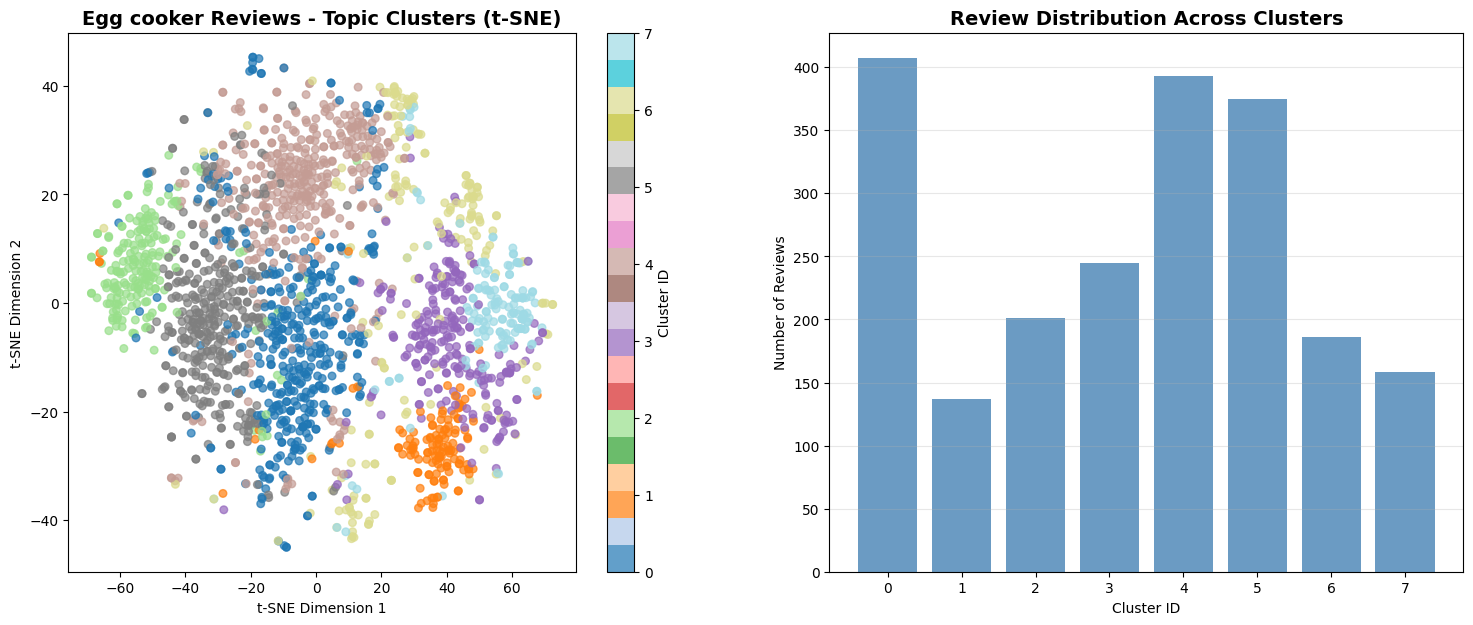

In [11]:
# PART 1: Visualization - Embedding & Clustering Analysis

# Visualize clusters using t-SNE (2D projection)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Cluster distribution
scatter = axes[0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=df_reviews['cluster'], cmap='tab20', alpha=0.7, s=30)
axes[0].set_title('Egg cooker Reviews - Topic Clusters (t-SNE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, ax=axes[0], label='Cluster ID')

# Plot 2: Cluster size distribution
cluster_counts = df_reviews['cluster'].value_counts().sort_index()
axes[1].bar(cluster_counts.index, cluster_counts.values, color='steelblue', alpha=0.8)
axes[1].set_title('Review Distribution Across Clusters', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Number of Reviews')
axes[1].grid(axis='y', alpha=0.3)


In [12]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
score = silhouette_score(embeddings, cluster_labels)
print("Silhouette Score:", score)


print("CH Score:", calinski_harabasz_score(embeddings, cluster_labels))
print("DB Score:", davies_bouldin_score(embeddings, cluster_labels))

Silhouette Score: 0.04490712285041809
CH Score: 95.15264892578125
DB Score: 3.682014979654795


In [13]:
# Extract and display sample reviews from each cluster (topic analysis)
print("CLUSTER TOPIC ANALYSIS")

cluster_topics = {}
for cluster_id in range(n_clusters):
    cluster_reviews = df_reviews[df_reviews['cluster'] == cluster_id]
    # Get a representative sample
    sample_review = cluster_reviews['review'].iloc[0]
    cluster_topics[cluster_id] = {
        'count': len(cluster_reviews),
        'sample': sample_review[:150] + "..." if len(sample_review) > 150 else sample_review
    }
    print(f"\nCluster {cluster_id} ({cluster_topics[cluster_id]['count']} reviews):")
    print(f"  Sample: {cluster_topics[cluster_id]['sample']}")

CLUSTER TOPIC ANALYSIS

Cluster 0 (407 reviews):
  Sample: It is well made and cleans up easily. Price for this item is well below those for similar items. Mostly satisfied with how this item performs except t...

Cluster 1 (137 reviews):
  Sample: I bought three of these, one for myself and one for each of my roommates. We LOVE them. Super easy to use and clean up (except for where the water goe...

Cluster 2 (201 reviews):
  Sample: I'm old lady of 84, too many instructions and time, was very hard to puncher the eggs, took me quite a while to get it done, finally cooked and some w...

Cluster 3 (245 reviews):
  Sample: The product is great but charging me more for shipping tha. I  paid for the product is out of line. I tried adding g it to my bigger order for free sh...

Cluster 4 (393 reviews):
  Sample: I recently got my hands on the MyMini 7-Egg Cooker, and I have to say, I'm pretty pleased overall! 👍 The quality of the cooker seems top-notch, and it...

Cluster 5 (375 reviews):
 

In [ ]:
n_clusters = 8
total_target = 800
per_cluster = total_target // n_clusters  

sampled_dfs = []

for c in range(n_clusters):
    cluster_df = df_reviews[df_reviews['cluster'] == c]
    # Randomly select per_cluster reviews from each cluster 
    sampled_cluster = cluster_df.sample(n=per_cluster, random_state=42)
    sampled_dfs.append(sampled_cluster)

df_sampled = pd.concat(sampled_dfs, ignore_index=True)

print("total reviews：", len(df_sampled))
print(df_sampled['cluster'].value_counts().sort_index())

all_reviews_text = "\n\n---REVIEW---\n\n".join(df_sampled['review'].tolist())

总共抽到的评论数： 800
cluster
0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
Name: count, dtype: int64


### OpenAI API analysis

In [32]:
# from google.colab import userdata
# OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
# os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
# print("OpenAI API key loaded")

# from openai import OpenAI
# client = OpenAI(api_key=OPENAI_API_KEY)

In [30]:
# !pip install openai python-dotenv
import os
from dotenv import load_dotenv
from openai import OpenAI
load_dotenv()

OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key=OPENAI_API_KEY)

In [18]:
# Prepare the analysis prompt
# Prompt 1
analysis_prompt = f"""You are an expert product analyst. Analyze the following {len(all_reviews_text)} customer reviews for an egg cooker.

Your task is to extract VISUAL and STRUCTURAL information useful for generating product images. Focus on:

1. **Structure & Dimensions**: Height, number of levels/tiers, platform arrangement, base design
2. **Materials & Textures**: Fabric types (plush, carpet, sisal), surface textures
3. **Key Components**: Scratching posts, cat houses/condos, perches, ladders, hammocks
4. **Design Elements**: Hanging toys, pom-poms, color schemes, platform shapes
5. **Overall Aesthetic**: Sturdy/wobbly, compact/spacious style

Provide a JSON output with this structure:
{{
  "structure": {{
    "height": "description",
    "tiers": "number and arrangement",
    "base": "stability and design"
  }},
  "materials": {{
    "primary_covering": "material type",
    "textures": ["list of textures mentioned"],
    "quality": "overall quality perception"
  }},
  "components": {{
    "scratching_posts": "description",
    "enclosed_spaces": "cat houses/condos details",
    "platforms": "types and sizes",
    "toys": "hanging toys, balls, etc."
  }},
  "colors": {{
    "primary": "main color",
    "accents": ["additional colors"]
  }},
  "keywords": ["descriptive adjectives from reviews"],
  "image_prompt": "A comprehensive prompt for image generation based on all extracted features"
}}

CUSTOMER REVIEWS:
---
{all_reviews_text}
---

Provide ONLY valid JSON output, no additional text or markdown.
"""

# Call OpenAI API

try:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert product analyst. Output only valid JSON."},
            {"role": "user", "content": analysis_prompt}
        ],
        temperature=0.3,
        max_tokens=2000
    )

    llm_output = response.choices[0].message.content
    print("Response received!\n")

    # Clean and parse JSON
    # Remove markdown code blocks if present
    llm_output_clean = llm_output.strip()
    if llm_output_clean.startswith("```"):
        llm_output_clean = llm_output_clean.split("```")[1]
        if llm_output_clean.startswith("json"):
            llm_output_clean = llm_output_clean[4:]
    llm_output_clean = llm_output_clean.strip()

    # Parse JSON
    extracted_features = json.loads(llm_output_clean)

    # Display results
    print("EXTRACTED VISUAL FEATURES")
    print(json.dumps(extracted_features, indent=2))

    # Save to file
    output_path = 'cat_tree_extracted_features.json'
    with open(output_path, 'w') as f:
        json.dump(extracted_features, f, indent=2)
    print(f"Features saved to: {output_path}")

    # Display the image generation prompt
    print("FINAL IMAGE GENERATION PROMPT")
    print(extracted_features.get('image_prompt', 'N/A'))

except Exception as e:
    print(f"Error: {str(e)}")

Response received!

EXTRACTED VISUAL FEATURES
{
  "structure": {
    "height": "small and compact, suitable for storage in cabinets or small spaces",
    "tiers": "single level design",
    "base": "stable with a flat base, but some reviews mention it feels flimsy"
  },
  "materials": {
    "primary_covering": "plastic",
    "textures": [
      "smooth",
      "glossy"
    ],
    "quality": "perceived as cheap but functional, some issues with durability"
  },
  "components": {
    "scratching_posts": "not applicable",
    "enclosed_spaces": "not applicable",
    "platforms": "holds up to 7 eggs, includes a tray for poaching or omelets",
    "toys": "not applicable"
  },
  "colors": {
    "primary": "varies (teal, red, lime green)",
    "accents": [
      "none"
    ]
  },
  "keywords": [
    "easy to use",
    "compact",
    "affordable",
    "perfect eggs",
    "loud alarm",
    "easy to clean",
    "quick cooking"
  ],
  "image_prompt": "A compact, single-tier egg cooker made of smoo

In [19]:
# Improve prompt to only retain positive features
# Prompt 2
improved_prompt = f"""
You are an expert product analyst.

We have a set of customer reviews for an egg cooker.

Your task:

1. POSITIVE VISUAL FEATURES:
   - Only describe physical and visual features that customers LIKED
   - Example aspects: shape, color, compactness, trays, lid, materials, lights, overall look

2. NEGATIVE VISUAL FEATURES:
   - Only describe physical and visual issues that customers DISLIKED
   - Example aspects: looks cheap, too small, flimsy, unstable, poor materials, ugly colors

3. IDEAL_IMAGE_PROMPT:
   - A rich image generation prompt that shows the egg cooker at its BEST,
     based ONLY on positive visual features.

4. REALISTIC_IMAGE_PROMPT:
   - A balanced prompt that reflects both positive features and common complaints,
     representing how the product truly looks in real life.

Output valid JSON in this format (no extra text):

{{
  "positive_features": {{...}},
  "negative_features": {{...}},
  "ideal_image_prompt": "prompt focusing on best features",
  "realistic_image_prompt": "balanced prompt"
}}
REVIEWS:
{all_reviews_text}
"""

# Call OpenAI API

try:
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert product analyst. Output only valid JSON."},
            {"role": "user", "content": improved_prompt}
        ],
        temperature=0.3,
        max_tokens=1800,
    )

    llm_output = response.choices[0].message.content
    print("Response received!\n")

    llm_output_clean = llm_output.strip()
    if llm_output_clean.startswith("```"):
        llm_output_clean = llm_output_clean.split("```")[1]
        if llm_output_clean.startswith("json"):
            llm_output_clean = llm_output_clean[4:]
    llm_output_clean = llm_output_clean.strip()

    extracted_features = json.loads(llm_output_clean)

    print("EXTRACTED POS/NEG FEATURES")
    print(json.dumps(extracted_features, indent=2))

    output_path = 'egg_cooker_pos_neg_features.json'
    with open(output_path, 'w') as f:
        json.dump(extracted_features, f, indent=2)
    print("Features saved to:", output_path)

    print("\nIDEAL IMAGE PROMPT")
    print(extracted_features.get('ideal_image_prompt', 'N/A'))

    print("\nREALISTIC IMAGE PROMPT")
    print(extracted_features.get('realistic_image_prompt', 'N/A'))

except Exception as e:
    print("Error:", str(e))

Response received!

EXTRACTED POS/NEG FEATURES
{
  "positive_features": {
    "compactness": "Customers appreciated the small and compact size, making it easy to store and ideal for small spaces like RVs and dorm rooms.",
    "color": "The egg cooker comes in attractive colors like teal and retro blue, which were well-liked by users.",
    "design": "The design is described as cute and visually appealing.",
    "ease of use": "The product is noted for being extremely easy to use, with clear instructions and minimal setup required."
  },
  "negative_features": {
    "cheap materials": "Some users mentioned that the product feels flimsy and is made of plastic, which gives it a cheap appearance.",
    "alarm sound": "The alarm sound when the eggs are done is described as loud and obnoxious, similar to a fire alarm, which many users found unpleasant.",
    "size limitations": "The cooker is too small for extra-large or jumbo eggs, with the lid not fitting properly over larger eggs."
  },
 

In [29]:
# Manually reduce negative words in the prompt
# Prompt 3
ideal_prompt = """
A compact electric rapid egg cooker in bright aqua teal plastic, 
featuring a capacity for 7 brown eggs arranged in a circle, 
a transparent dome-shaped lid with a top steam vent, 
a prominent white "MyMini" logo on the front, 
a single blue power toggle switch with a light indicator, 
small ergonomic side handles, sleek rounded base design, 
set against a clean white background, product photography style, high quality, smooth and glossy textures
"""

## Part 3 - Image Generation

### 3 prompts

In [32]:
import requests
import base64
from PIL import Image
from io import BytesIO
# Create output folder
output_folder = 'generated_images'
os.makedirs(output_folder, exist_ok=True)

# 3 prompts from Part B

# based line randomly selected
# prompts = {
#     "review_based": """A compact and colorful egg cooker with a smooth plastic finish, capable of holding up to 7 eggs on a single tier tray. It features a simple design with a stable base, though some users report issues with burning. The cooker is available in various colors such as teal, lime green, and retro blue. It is described as easy to use and quick, with a loud alarm indicating when the eggs are done. The overall aesthetic is practical and functional, suitable for small kitchens or as a gift.
# .""",
#     "positive_extracted": """A compact and colorful egg cooker with a sleek, modern design. It features a cute and adorable appearance with a retro blue or sea foam green color, perfectly fitting into a stylish kitchen. The cooker is equipped with a clear lid, a measuring cup with a piercer, and an egg rack, all neatly arranged for easy use.
# .""",
#     "realistic_manual": """A small and compact egg cooker with a cute design, available in retro blue or sea foam green. It includes a clear lid and a measuring cup with a piercer. The cooker is made of lightweight materials, with some visible signs of wear like rust or staining on the metal plate. The alarm is loud and noticeable, resembling a fire alarm.
# .""",
#     "ideal_manual":"""A compact electric rapid egg cooker in bright aqua teal plastic, 
# featuring a capacity for 7 brown eggs arranged in a circle, 
# a transparent dome-shaped lid with a top steam vent, 
# a prominent white "MyMini" logo on the front, 
# a single blue power toggle switch with a light indicator, 
# small ergonomic side handles, sleek rounded base design, 
# set against a clean white background, product photography style, high quality, smooth and glossy textures
# ."""
# }


# cluster-based slected 
prompts = {
    "review_based": """A compact, single-tier egg cooker made of smooth, glossy plastic. It is available in various colors such as teal, red, and lime green. The design is simple and functional, with a flat base for stability. The cooker includes a tray for holding up to 7 eggs and an additional tray for poaching or making omelets. Despite its affordable and somewhat flimsy appearance, it is praised for its ease of use and quick cooking capabilities. The cooker emits a loud alarm when the eggs are done, ensuring you won't forget about them.
.""",
    "positive_extracted": """A compact and cute egg cooker in a vibrant teal color, sitting neatly on a kitchen counter. The design is sleek and modern, with a clear lid showcasing perfectly cooked eggs inside. The cooker is surrounded by fresh eggs and a small measuring cup, highlighting its ease of use and efficiency.
.""",
    "realistic_manual": """A small, teal-colored egg cooker with a simple design, made of plastic materials. The lid is slightly ajar, showing a tight fit over large eggs. The cooker is on a kitchen counter, with a loud alarm sound indicated by sound waves. Despite its compact size, it efficiently cooks eggs, with a few water stains visible on the metal heating plate.
.""",

    "ideal_manual": """A compact electric rapid egg cooker in bright aqua teal plastic, 
featuring a capacity for 7 brown eggs arranged in a circle, 
a transparent dome-shaped lid with a top steam vent, 
a prominent white "MyMini" logo on the front, 
a single blue power toggle switch with a light indicator, 
small ergonomic side handles, sleek rounded base design, 
set against a clean white background, product photography style, high quality, smooth and glossy textures"""
}


# RAG-based selected
# prompts = {
#     "review_based": """"A compact and cute egg cooker with a dome lid, capable of holding up to 7 eggs on a single level tray. The cooker is primarily made of smooth plastic with a metal heating plate. It features a small, stable base and is available in colors like sea foam green and teal. The design is simple and efficient, with a loud alarm to indicate when cooking is complete. The cooker includes a poaching/omelet pan and a measuring cup with an egg piercer. It is perceived as durable and well-made, despite some mentions of cheap plastic parts.

# .""",
#     "positive_extracted": """A vibrant and compact egg cooker with a cute design, featuring a dome-shaped lid and colorful options like aqua and sea foam green, placed in a modern kitchen setting.

# .""",
#     "realistic_manual": """A compact egg cooker with a cute design, available in limited colors like aqua, featuring a dome-shaped lid and lightweight materials, but with a slightly flimsy appearance and limited capacity for larger eggs.

# .""",
#     "ideal_manual": """"A compact electric rapid egg cooker in bright aqua teal plastic, 
# featuring a capacity for 7 brown eggs arranged in a circle, 
# a transparent dome-shaped lid with a top steam vent, 
# a prominent white "MyMini" logo on the front, 
# a single blue power toggle switch with a light indicator, 
# small ergonomic side handles, sleek rounded base design, 
# set against a clean white background, product photography style, high quality, smooth and glossy textures"""""
# }

### DALL-E

In [33]:
dalle_images = {}

for prompt_name, prompt_text in prompts.items():
    print(f"\nGenerating: {prompt_name}...")

    try:
        response = client.images.generate(
            model="dall-e-3",
            prompt=prompt_text,
            size="1024x1024",
            quality="standard",
            n=1
        )

        image_url = response.data[0].url
        dalle_images[prompt_name] = image_url

        # Download and save image
        img_response = requests.get(image_url)
        img = Image.open(BytesIO(img_response.content))
        save_path = f"{output_folder}/dalle3_{prompt_name}.png"
        img.save(save_path)

        print(f"Saved: dalle3_{prompt_name}.png")

    except Exception as e:
        print(f"Error: {str(e)}")



Generating: review_based...
Saved: dalle3_review_based.png

Generating: positive_extracted...
Saved: dalle3_positive_extracted.png

Generating: realistic_manual...
Saved: dalle3_realistic_manual.png

Generating: ideal_manual...
Saved: dalle3_ideal_manual.png



--- DALL-E 4 Results ---


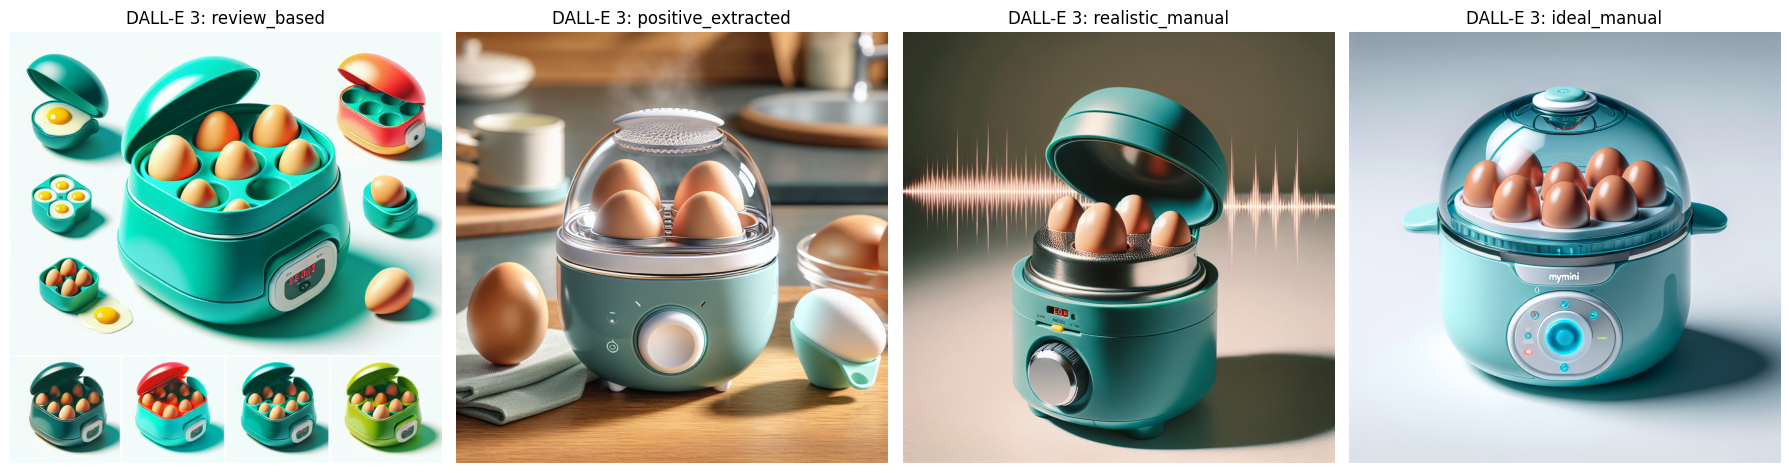

In [34]:
# Display DALL-E images
print("\n--- DALL-E 4 Results ---")
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
for idx, (prompt_name, _) in enumerate(prompts.items()):
    img_path = f"{output_folder}/dalle3_{prompt_name}.png"
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f"DALL-E 3: {prompt_name}", fontsize=12)
        axes[idx].axis('off')
plt.tight_layout()
plt.savefig(f"{output_folder}/dalle3_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

### Stable Diffusion


Generating: review_based...
Saved: sd_review_based.png

Generating: positive_extracted...
Saved: sd_positive_extracted.png

Generating: realistic_manual...
Saved: sd_realistic_manual.png

Generating: ideal_manual...
Saved: sd_ideal_manual.png

--- Stable Diffusion Results ---


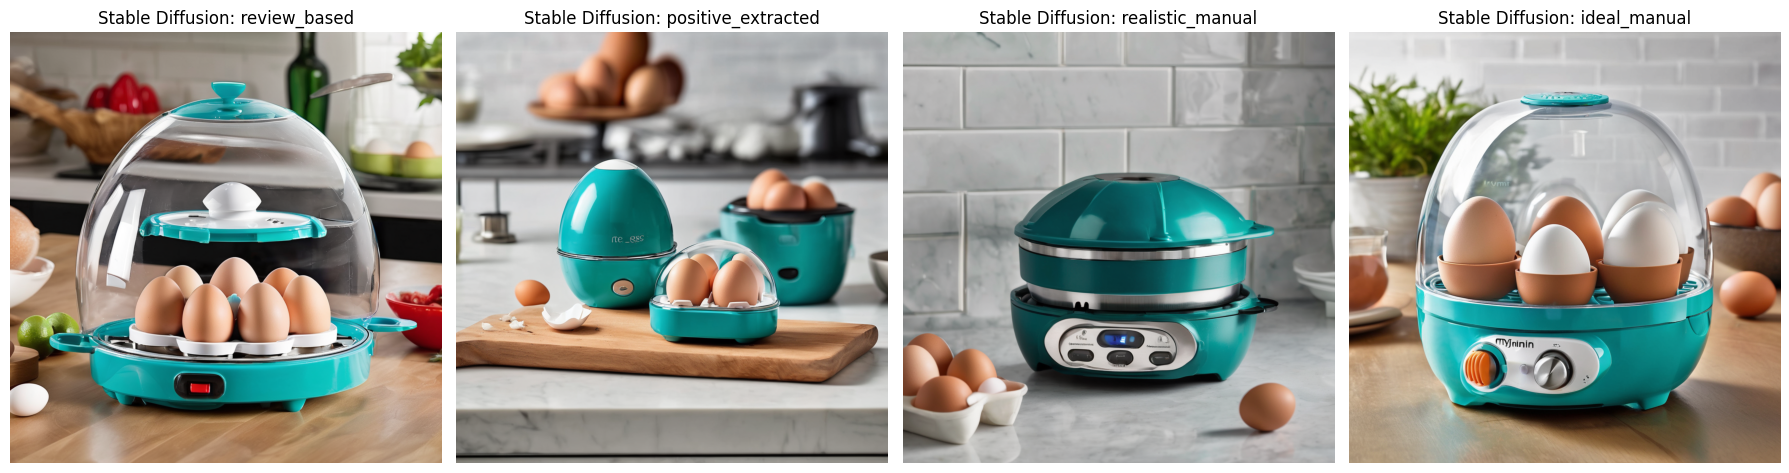

In [25]:
try:
    STABILITY_API_KEY = os.environ.get("STABILITY_API_KEY")
    

    sd_images = {}

    for prompt_name, prompt_text in prompts.items():
        print(f"\nGenerating: {prompt_name}...")

        response = requests.post(
            "https://api.stability.ai/v1/generation/stable-diffusion-xl-1024-v1-0/text-to-image",
            headers={
                "Content-Type": "application/json",
                "Authorization": f"Bearer {STABILITY_API_KEY}"
            },
            json={
                "text_prompts": [{"text": prompt_text, "weight": 1}],
                "cfg_scale": 7,
                "height": 1024,
                "width": 1024,
                "samples": 1,
                "steps": 30
            }
        )

        if response.status_code == 200:
            data = response.json()
            img_data = base64.b64decode(data["artifacts"][0]["base64"])
            img = Image.open(BytesIO(img_data))
            save_path = f"{output_folder}/sd_{prompt_name}.png"
            img.save(save_path)
            sd_images[prompt_name] = save_path
            print(f"Saved: sd_{prompt_name}.png")
        else:
            print(f"Error: {response.status_code} - {response.text}")

    # Display SD images
    print("\n--- Stable Diffusion Results ---")
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    for idx, (prompt_name, _) in enumerate(prompts.items()):
        img_path = f"{output_folder}/sd_{prompt_name}.png"
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].set_title(f"Stable Diffusion: {prompt_name}", fontsize=12)
            axes[idx].axis('off')
    plt.tight_layout()
    plt.savefig(f"{output_folder}/sd_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

except Exception as e:
    print(f"{str(e)}")

### Nano Banana


Generating (Imagen): review_based...
Saved: gimg_review_based.png

Generating (Imagen): positive_extracted...
Saved: gimg_positive_extracted.png

Generating (Imagen): realistic_manual...
Saved: gimg_realistic_manual.png

Generating (Imagen): ideal_manual...
Saved: gimg_ideal_manual.png

--- Imagen (Google GenAI) Results ---


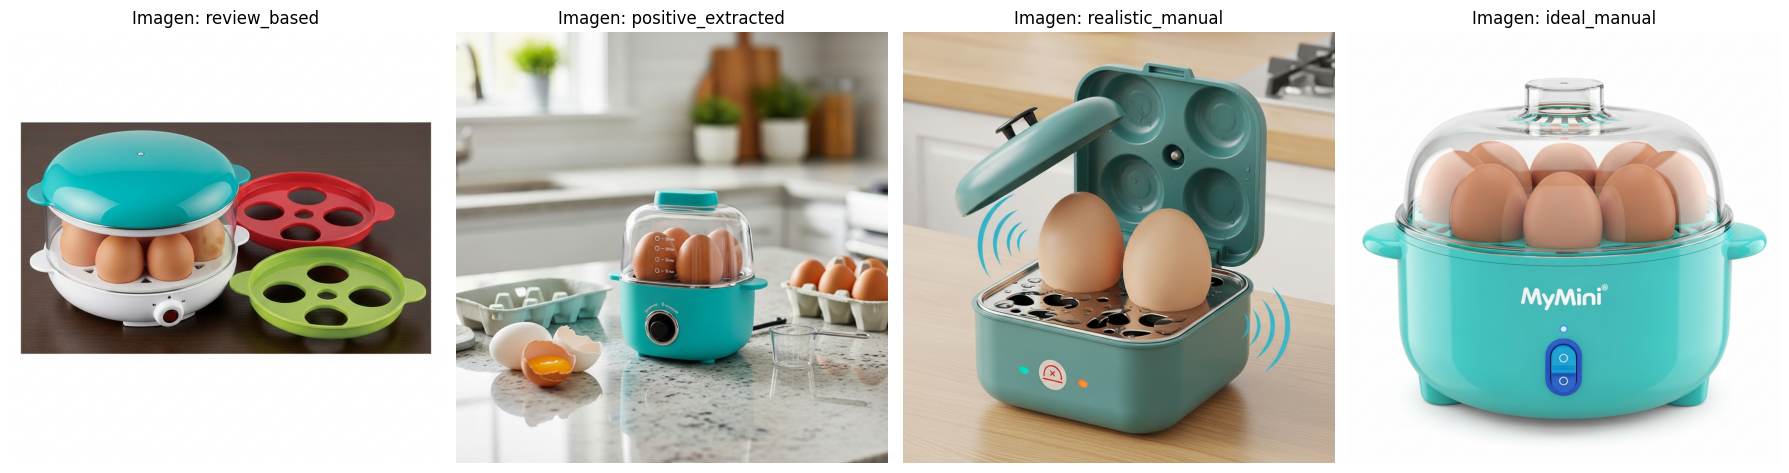

Comparison image saved to: generated_images/gimg_comparison.png


In [26]:
# !pip install google-genai
import os
from google import genai
from google.genai import types
from PIL import Image
import matplotlib.pyplot as plt

#
# output_folder = "/content/drive/MyDrive/GenAI/egg_cooker_images"

os.makedirs(output_folder, exist_ok=True)

# Initialize GenAI client
client = genai.Client()

try:
    gimg_images = {}  # to store generated image paths

    # Generate images with Imagen model
    for prompt_name, prompt_text in prompts.items():
        print(f"\nGenerating (Imagen): {prompt_name}...")

        response = client.models.generate_images(
            model="imagen-4.0-generate-001",
            prompt=prompt_text,
            config=types.GenerateImagesConfig(
                number_of_images=1,  #
            ),
        )

      
        if not response.generated_images:
            print(f"No images returned for prompt: {prompt_name}")
            continue

        generated_image = response.generated_images[0]


        img = generated_image.image  # 直接取出 PIL Image 对象

 
        save_path = os.path.join(output_folder, f"gimg_{prompt_name}.png")
        img.save(save_path)
        gimg_images[prompt_name] = save_path

        print(f"Saved: gimg_{prompt_name}.png")

    # -----------------------------
    # show generated images
    # -----------------------------
    if len(gimg_images) == 0:
        print("No images were generated, nothing to display.")
    else:
        print("\n--- Imagen (Google GenAI) Results ---")

        prompt_names = list(prompts.keys())
        n = len(prompt_names)

        fig, axes = plt.subplots(1, 4, figsize=(18, 6))

   
        if n == 1:
            axes = [axes]

        for idx, prompt_name in enumerate(prompt_names):
            img_path = os.path.join(output_folder, f"gimg_{prompt_name}.png")
            if os.path.exists(img_path):
                img = Image.open(img_path)
                axes[idx].imshow(img)
                axes[idx].set_title(f"Imagen: {prompt_name}", fontsize=12)
                axes[idx].axis("off")
            else:
                axes[idx].set_title(f"Missing: {prompt_name}", fontsize=12)
                axes[idx].axis("off")

        plt.tight_layout()
        comp_save_path = os.path.join(output_folder, "gimg_comparison.png")
        plt.savefig(comp_save_path, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Comparison image saved to: {comp_save_path}")

except Exception as e:
    print(f"Error while generating images with Imagen: {str(e)}")